In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.


In [2]:
stack = 'MD589'
dataFolderName = 'NoCoors_RandomFalseMatched'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [3]:
def fun_get_learning_data_path(what, stack, data_set, structure_name, method, ext=None):
    LERANING_ROOT_PATH = '/shared/blob_matching_atlas/training_weight'
    if what=='weight':
        fn = 'weight.bp'
    elif what=='learning_parameters':
        fn = 'learning_parameters.pkl'
    elif what=='maxSimDiff':
        fn = 'maxSimDiff.bp'
    else:   
        assert ext is not None, 'Please specify extension'
        fn = what + ext
    
    fp = os.path.join(LERANING_ROOT_PATH, stack, data_set, structure_name, method, fn)
    return fp
        
        

In [4]:
def load_training_weight(what, stack, data_set, structure_name, method, ext=None):
    fp = fun_get_learning_data_path(what, stack, data_set, structure_name, method, ext=None)
    print('Loading %s'%fp)
    if not os.path.isfile(fp):
        sys.stderr.write('Warnning: File does not exist in the shared folder. Try to download from s3...\n')
        try:
            download_from_s3(fp)
        except:
            sys.stderr.write('Loading file %s failed.\n'%fp)
    return load_data(fp)

In [5]:
# Annotation data:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


In [6]:
load_structure = '7N'
data_tag = 'SGD_10_02'
data_weight = {}
data_maxSimDiff = {}

for load_structure in structure_section_list.keys():
    try:
        data_weight[load_structure] = load_training_weight(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag)
        data_maxSimDiff[load_structure] = load_training_weight(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag)
    except:
        sys.stderr.write('Missing strucutre %s\n'%load_structure)

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IC/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IC/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sp5O/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sp5O/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNC/SGD_10_02/weight.bp
Loading

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/3N/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/3N/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sol/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sol/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/6N/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/6N/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LVe/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LVe/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Pr5VL/SGD_10_02/weight.bp
Loadi

In [7]:
# load_training_weight(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name='Tz', method='SGD_9_26')

In [8]:
upload_to_s3('/shared/blob_matching_atlas',is_dir=True)

aws s3 cp --recursive "/shared/blob_matching_atlas" "s3://mousebrainatlas-data/blob_matching_atlas"


Training set:
* Positive: typical blob pairs in each structure. Similarity between blobs in consecutive sections is measured by {area, eccentricity}, evenly weightled ( weight = {0.5, 0.5} )
* Negative: false typical blob pairs: given a typical blob, 200 blobs that are more than 3000 pixels away from this typical  blob are randomly collected. In fact, this pairs are not typical at all. If we do the matching between blobs distantly separated and collect those pairs with high similarity, what is the meaning of the resulting optimized weight? The resulting wight will not emphasize the importance of area (and eccentricity). 

## Overall statistics of maxSimDiff

In [36]:
{tempStr: np.mean(data_maxSimDiff[tempStr]) for tempStr in data_maxSimDiff.keys()}

{'10N': 0.95639687695132924,
 '12N': 0.96246103358438539,
 '3N': 0.96380377971163744,
 '4N': 0.97121377140729714,
 '5N': 0.96632773976377961,
 '5TT': 0.95577854537058415,
 '6N': 0.96304740721102866,
 '7N': 0.97052542701149436,
 '7n': 0.9195882166359568,
 '8n': 0.96115844938980621,
 'AP': 0.94712970058608059,
 'APT': 0.93970041993649889,
 'Amb': 0.97105694054028302,
 'Cb': 0.94536217,
 'DC': 0.94290284000000013,
 'DRD': 0.96238686991869926,
 'DTgP': 0.95276092839053816,
 'Dk': 0.9500771587091591,
 'ECu': 0.95822203086768309,
 'EW': 0.96987926990935469,
 'Gr': 0.94706216973391388,
 'IC': 0.92997844000000007,
 'IF': 0.94054433143219263,
 'IO': 0.93599094999999999,
 'IPA': 0.93537646233974359,
 'IPC': 0.95421716780890642,
 'IPL': 0.94173980000000013,
 'IPR': 0.95400321262005616,
 'LC': 0.95448571950354621,
 'LPB': 0.94104272,
 'LRt': 0.95682438000000003,
 'LSO': 0.95579369206088993,
 'LVe': 0.9652935583827843,
 'Li': 0.95088402564102548,
 'MPB': 0.95572693582145074,
 'MVe': 0.9406744261114

## Overall statistics of weights:

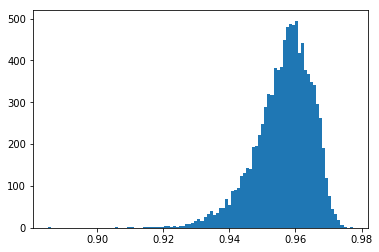

In [34]:
plt.hist(data_maxSimDiff['10N'],bins=100);

In [9]:
# Statistics of obtained weight for each structure:
structure_weight_mean = {}
structure_weight_std = {}
for structure_name in data_maxSimDiff.keys():
    structure_weight_mean[structure_name] = np.mean(data_weight[structure_name], axis=0).flatten()
    structure_weight_std[structure_name] = np.std(data_weight[structure_name], axis=0).flatten()
    

In [10]:
learning_features = ['area', 'eccentricity', 'orientation','compactness', 'moments_hu1','moments_hu2', 'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6', 'moments_hu7']

In [11]:
mean_feature_weight_for_each_structure = {}
for idx in range(len(learning_features)):
    feature_name = learning_features[idx]
    mean_feature_weight_for_each_structure[feature_name] = []
    for structure_name in structure_weight_mean.keys():
        mean_feature_weight_for_each_structure[feature_name].append(structure_weight_mean[structure_name][idx])

In [15]:
mean_feature_vector = []
for temp in learning_features:
    mean_feature_vector.append(mean_feature_weight[temp])

mean_feature_weight averages over the weight of all the strucutre in the brain stem. What does it mean? The average optimzied weight? Is it correct to pre-collect typical blobs and do the training? How about optimizing the weight while collecting the typical blobs? 

1. Area is the most important feature for matching typical blobs against blobs randomly selected from the other area of the brain stem.
2. eccentricity, Hu moment 2,5,6,7 are useful features with average weights around 0.07 ~ 0.1
3. Compactness is useless in this case

In [32]:
mean_feature_weight

{'area': 0.60391835842624209,
 'compactness': 0.014677627194826509,
 'eccentricity': 0.13234106595239992,
 'moments_hu1': 0.021635780059262456,
 'moments_hu2': 0.072056671567163957,
 'moments_hu3': 0.0066555436313987248,
 'moments_hu4': 0.007603345765240588,
 'moments_hu5': 0.046569412200079395,
 'moments_hu6': 0.01763253531479091,
 'moments_hu7': 0.039923635893439245,
 'orientation': 0.036986023995156221}

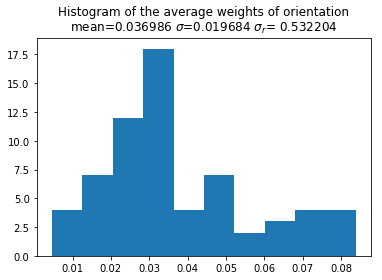

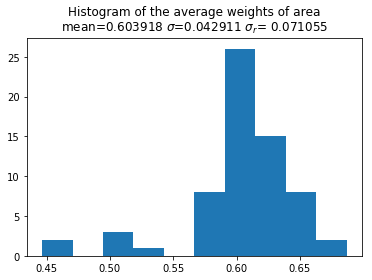

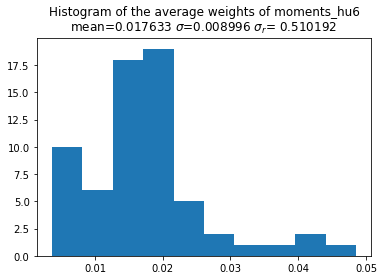

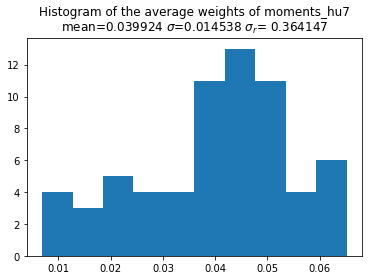

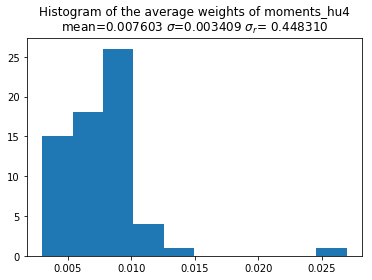

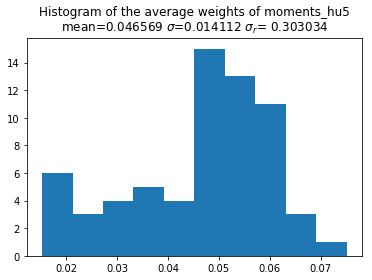

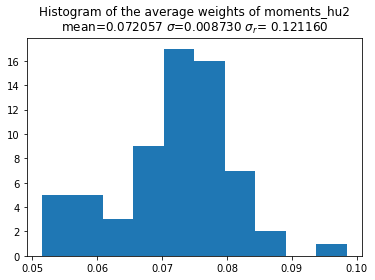

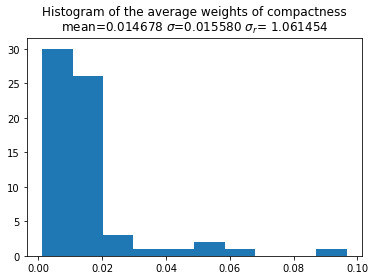

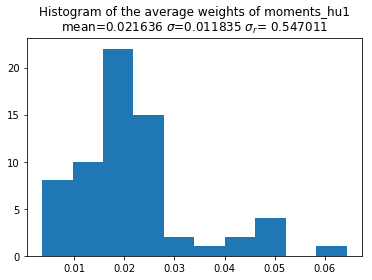

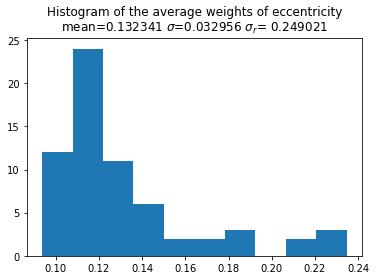

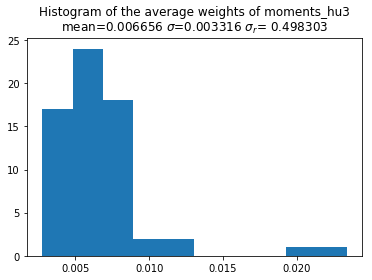

In [18]:
mean_feature_weight = {}
std_feature_weight = {}
for feature_name in mean_feature_weight_for_each_structure.keys():
    mean_feature_weight[feature_name] = np.mean(mean_feature_weight_for_each_structure[feature_name])
    std_feature_weight[feature_name] = np.std(mean_feature_weight_for_each_structure[feature_name])
    plt.figure()
    plt.hist(mean_feature_weight_for_each_structure[feature_name]);
    plt.title('Histogram of the average weights of %s\nmean=%f $\sigma$=%f $\sigma_r$= %f'%(feature_name, mean_feature_weight[feature_name], std_feature_weight[feature_name], std_feature_weight[feature_name]/mean_feature_weight[feature_name]))

## Best weight obtained for each structure

We are about the best weight vectore we can get for each strucutre, which gives largest difference between true-positive rate and false-positive rate. 

First, we plot the histograms of the best weight of each feature for all the strucutres. The best weight vector averaged over all the structure is in the first row. For comparison, the second row shows the average weight vector averaged over all the stuructre. 

|    |'area' | 'eccentricity' | 'compactness' | 'moments_hu1' | 'moments_hu2' | 'moments_hu3' | 'moments_hu4' | 'moments_hu5' | 'moments_hu6' | 'moments_hu7'|
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | 
| Best | 0.54529778 | 0.34717091 | 0.00486215 | 0.00418092 | 0.04052215 | 0.00288387 | 0.00455112, | 0.0154834 | 0.01607853 | 0.01896915
| Average | 0.51327775 | 0.10243768 | 0.00448164 | 0.00485839 | 0.07829191 | 0.02451909 | 0.04050866 | 0.08084159 | 0.06995134 |0.08083194 |

The weight of eccentricity is quite different between the best weight and the average weight and in both vectors, the weight of 'area' is around 0.5. Our initial weight is weight(area, eccentricity) = {0.5, 0.5}, I am not sure whether the resulting weight reflects the weight we use for initial typical blob collection or not. In other words, how should we measure the bias introduced by the initial matching? 

We hope to get a good weight vector for typical blob collection. For unsupervised learning, we can only use one weight ( right? ) for typical blob collection. Therefore, if the optimized weight vectors we obtained are similar for each strucutre, their average might be a good weight vector for unsupervised blob matching. Here we measure the similarity between weight vectors by calculating the cosine of the angle between vectors: 
$$ cos(\theta_{v1, v2}) = \frac{v_1 \cdot v_2}{|v_1||v_2|}  $$

In [19]:
def fun_vector_distance_cos(vec1, vec2):
    vec1 = np.array(vec1.flatten(), dtype=np.float)
    vec2 = np.array(vec2.flatten(), dtype=np.float)
    cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_angle

In [20]:
best_weight = {}
for structure_name in data_weight.keys():
    best_weight[structure_name] =  fun_find_max(data_weight[structure_name], data_maxSimDiff[structure_name], mode='returnFirst')[0].flatten()

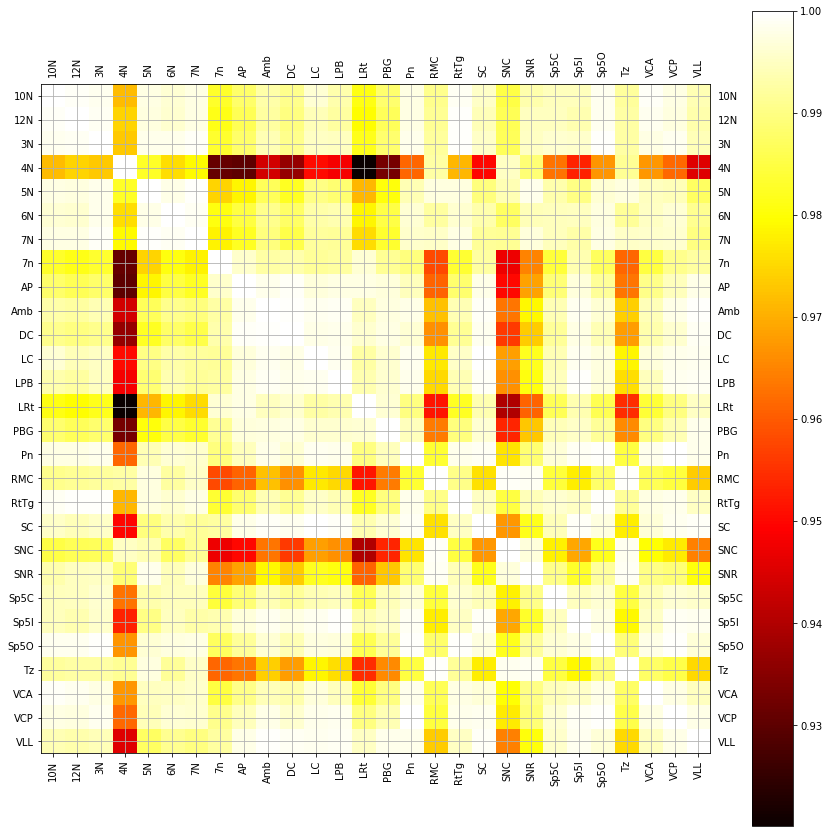

In [37]:
structure_list = np.sort(STRUCTURES_LIST)
# structure_list = np.sort(best_weight.keys())
tempList = []
for temp in structure_list:
    tempList.append(best_weight[temp])
best_weight_flatten = np.column_stack(tuple(tempList))
# Similarity between best weight vector
weight_vector_simi_mat = np.array([[fun_vector_distance_cos(best_weight[temp1], best_weight[temp2]) for temp1 in structure_list] for temp2 in structure_list])
plt.figure(figsize=(15,15))
plt.imshow(weight_vector_simi_mat,cmap=plt.cm.hot)
plt.colorbar()
plt.xticks(np.arange(0, len(structure_list)),structure_list, rotation='vertical');
plt.yticks(np.arange(0, len(structure_list)),structure_list);
plt.tick_params(labelbottom='on',labeltop='on')
plt.tick_params(labelleft='on',labelright='on')
plt.grid()

In [39]:
best_weight['12N']

array([ 0.57847699,  0.3984281 ,  0.        ,  0.00130356,  0.02051931,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00127203])

In [40]:
best_weight['10N']

array([ 0.55660024,  0.39448505,  0.02633376,  0.        ,  0.01788738,
        0.00469357,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [38]:
best_weight['3N']

array([ 0.57162246,  0.40437741,  0.00140636,  0.        ,  0.        ,
        0.02259376,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [26]:
best_weight['IPL']

array([ 0.6004406 ,  0.28856019,  0.01114399,  0.01149735,  0.00794896,
        0.03204182,  0.01937622,  0.01823728,  0.        ,  0.01075359,  0.        ])

In [27]:
np.mean(best_weight_flatten, axis=1)

array([ 0.53655065,  0.41277178,  0.00709985,  0.00467006,  0.00534061,
        0.01494578,  0.00160225,  0.00193243,  0.00827768,  0.00214731,
        0.0046616 ])

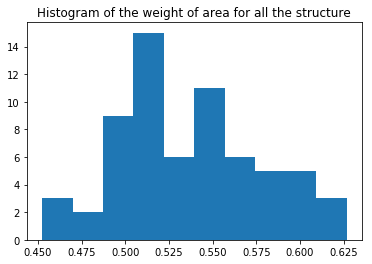

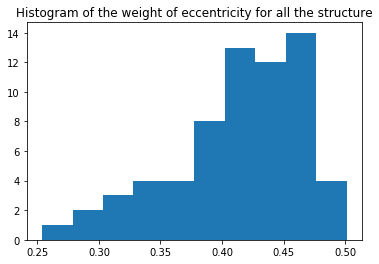

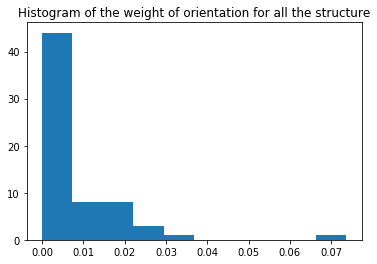

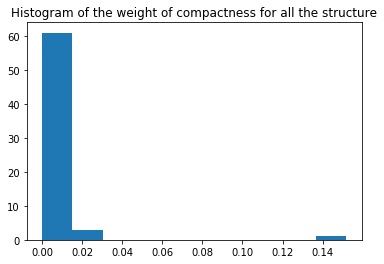

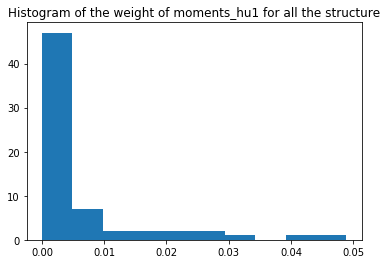

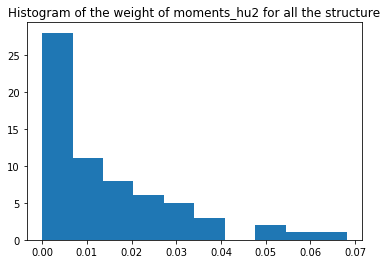

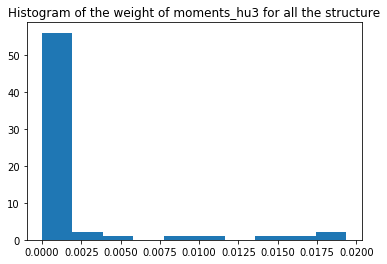

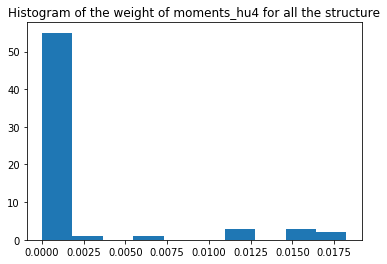

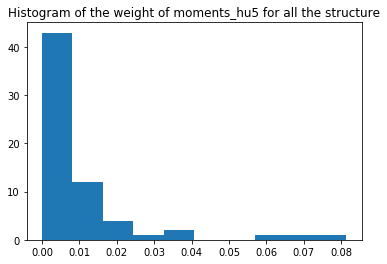

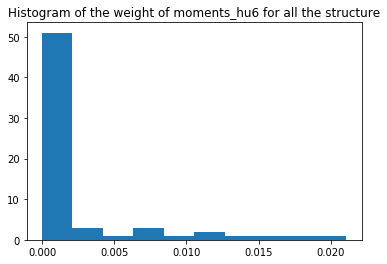

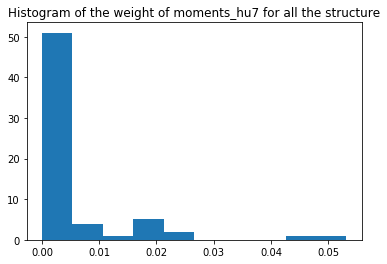

In [28]:
for idx in range(len(learning_features)):
    plt.figure()
    plt.hist(best_weight_flatten[idx]);
    plt.title('Histogram of the weight of %s for all the structure'%learning_features[idx])

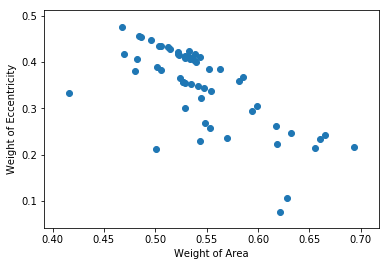

In [17]:
plt.scatter(best_weight_flatten[0], best_weight_flatten[1]);
plt.xlabel('Weight of Area')
plt.ylabel('Weight of Eccentricity')

Does this really mean that weight and area are the most two features for all the structures? Or the algorithms is trying to reproduce the weight we previously set? 

What's the properties of the region that compactness matters?

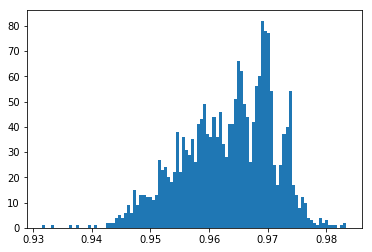

In [18]:
numBins = 100
plt.hist(data_maxSimDiff['7N'],bins=numBins);

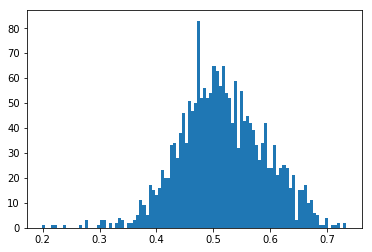

In [29]:
plt.hist(data_weight[load_structure][:,0].flatten(),bins=numBins);

In [75]:
tempOrder

array([ 581, 1485,  105, ...,   92,  532,  290])

In [30]:
tempOrder = np.argsort(data_maxSimDiff['8n'])[::-1]
tempVecDistance = []
for idx in tempOrder:
    tempVecDistance.append(fun_vector_distance_cos(data_weight['8n'][581], data_weight['8n'][idx]))

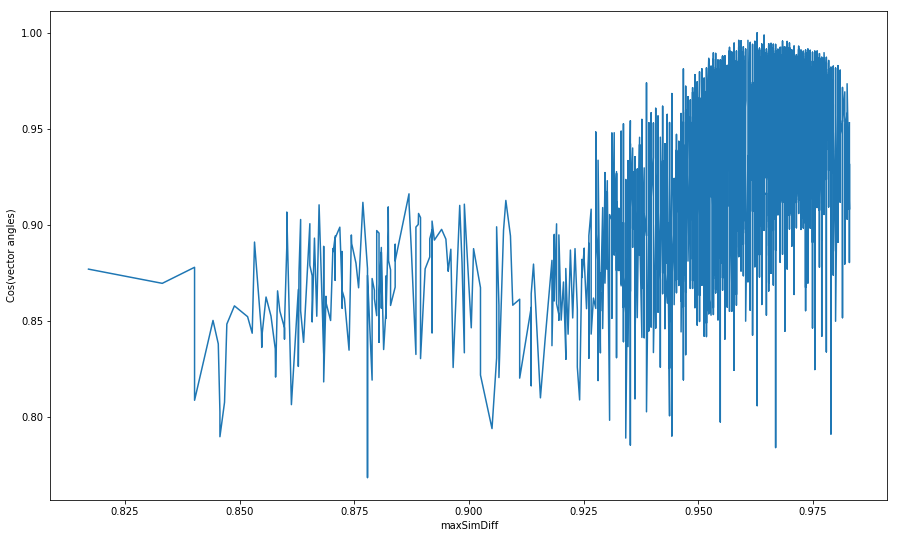

In [31]:
plt.figure(figsize=(15,9))
plt.plot(data_maxSimDiff['8n'][tempOrder], tempVecDistance)
plt.ylabel('Cos(vector angles)')
plt.xlabel('maxSimDiff')

1. Sort the maxSimDiff for 2000 SGD results of structure 7N, get the weight vector that has the highest maxSimDiff( defined as 'best weight') 
2. Compute the cosine of the angle between the best weight and the weight vector orderred in decreasing maxSimDiff
3. Plot
